In [1]:
import pandas as pd
import gc
import warnings
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import string
import numpy as np
import tensorflow as tf
from tqdm import tqdm


%pip install keras-tuner --upgrade
import keras_tuner as kt
from textblob import TextBlob
from nltk.text import Text  
import matplotlib.pyplot as plt
from nltk.probability import FreqDist

%pip install --user -U nltk

import re
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import random
import nltk as nlp

from sklearn.utils import resample
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stopwords = stopwords.words('english')
#add some unnecessary word to stopwords list
stopwords.append("rt")
stopwords.append("u")
stopwords.append("amp")
stopwords.append("w")
stopwords.append("th")

     |████████████████████████████████| 133 kB 4.2 MB/s 
     |████████████████████████████████| 1.5 MB 4.2 MB/s 
     |████████████████████████████████| 749 kB 40.8 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
#------------------------------- Profiling tweet data from democrats and republicans -----------------------------------------

#This is our dataset. It has labeled tweets and sentiment attached to them.
data_tweets = pd.read_csv('ExtractedTweets.csv')


print(np.unique(data_tweets.Party, return_counts=True))

(array(['Democrat', 'Republican'], dtype=object), array([42068, 44392]))


In [3]:
data_tweets.Tweet[0]

'Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the House… https://t.co/n3tggDLU1L'

In [4]:
#we created 2 different class as democrat and republican
democrat=data_tweets[data_tweets.Party=="Democrat"]
republican=data_tweets[data_tweets.Party=="Republican"]

In [5]:
def preprocess_text(df):

  ret_list=[]
  for d in df.Tweet:
    d=re.sub(r'http\S+', '', d) #remove links
    d=re.sub("[^a-zA-Z]", " ", d) #remove all characters except letters
    d=d.lower() #convert all words to lowercase
    d=nltk.word_tokenize(d) #split sentences into word
    d=[word for word in d if not word in set(stopwords)] #add to stopwords list if unnecessary words.
    d=" ".join(d)
    ret_list.append(d) #append words to list

  return ret_list

democrat_list = preprocess_text(democrat)
republican_list = preprocess_text(republican)

In [6]:
def additional_preprocessing(lst):

  lst=[word.replace("'","") for word in lst]
  lst=[word.replace("[", "") for word in lst]
  lst=[word.replace("]","") for word in lst]
  lst=[word.replace(",", "") for word in lst]
  return lst

#Contains words that republicans and democrats use :
democrat_tweets = additional_preprocessing(str(democrat_list).split())
republican_tweets = additional_preprocessing(str(republican_list).split())


#print("Democrat tweets word length:",len(democrat_tweets))
#print("Republican tweets word length:",len(republican_tweets))


In [7]:
#Frequency of words used by both parties 
fdist_democrat = FreqDist(democrat_tweets)
fdist_republican=FreqDist(republican_tweets)


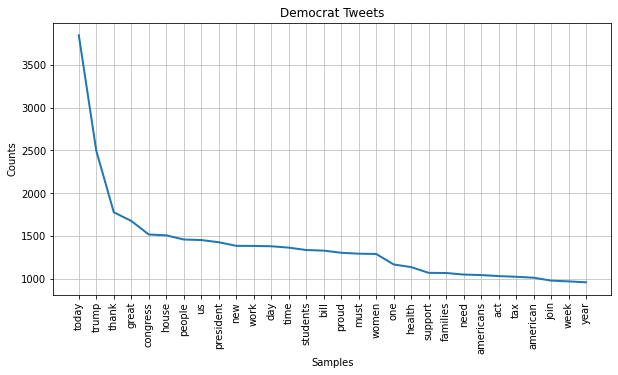

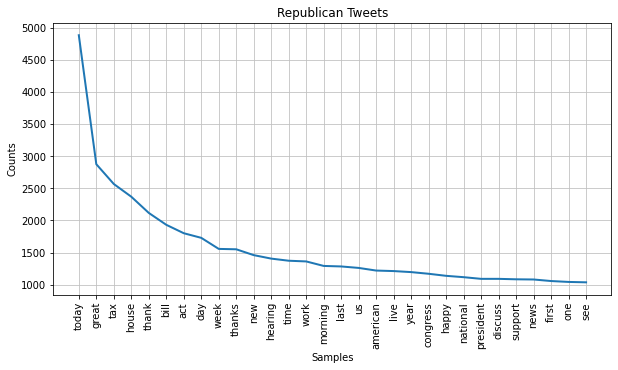

In [8]:
plt.subplots(figsize=(10,5))
fdist_democrat.plot(30,title="Democrat Tweets")
plt.subplots(figsize=(10,5))
fdist_republican.plot(30,title="Republican Tweets")


In [9]:

democrat_tweet=Text(democrat_tweets)
republican_tweet=Text(republican_tweets)


Lex Plot for Democrats :


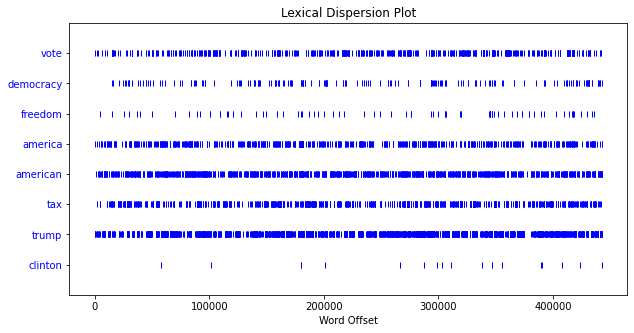

In [10]:
print("Lex Plot for Democrats :")
plt.subplots(figsize=(10,5))
democrat_tweet.dispersion_plot(["vote","democracy","freedom","america","american","tax","trump","clinton"])



Lex Plot for Republicans :


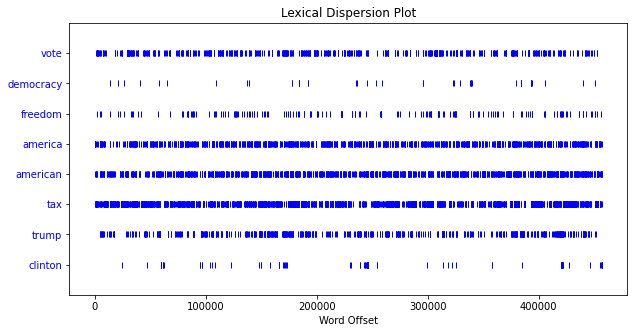

In [11]:
print("Lex Plot for Republicans :")
plt.subplots(figsize=(10,5))
republican_tweet.dispersion_plot(["vote","democracy","freedom","america","american","tax","trump","clinton"])


In [12]:
democratblob=TextBlob(str(democrat_tweets))
republicanblob=TextBlob(str(republican_tweets))

print("Democratic Sentiment : ",democratblob.sentiment)
print("Republican Sentiment : ",republicanblob.sentiment)

Democratic Sentiment :  Sentiment(polarity=0.1735748367205931, subjectivity=0.48133038511387327)
Republican Sentiment :  Sentiment(polarity=0.20987022440527497, subjectivity=0.476376033818089)


In [13]:
# -------------------------------- Emotion Detection Models ------------------------------------

In [14]:
#This is our dataset. It has labeled tweets and sentiment attached to them.
data = pd.read_csv('tweet_emotions.csv')

In [15]:
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [16]:
def preprocess_text_emotion(df):

  ret_list=[]
  for d in df.content:
    d=re.sub(r'http\S+', '', d) #remove links
    d=re.sub("[^a-zA-Z]", " ", d) #remove all characters except letters
    d=d.lower() #convert all words to lowercase
    d=nltk.word_tokenize(d) #split sentences into word
    d=[word for word in d if not word in set(stopwords)] #add to stopwords list if unnecessary words.
    d=" ".join(d)
    ret_list.append(d) #append words to list

  return ret_list

#Creating cleaned column
data['content'] = preprocess_text_emotion(data)

In [17]:
#Looks like our data doesn't have any empty values
data.isnull().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

In [18]:
#Although, we see that there is a imbalance in the 
data.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [19]:
#Splitting to train-test-val
data_size = data.shape[0]
print("Data Size: ",data_size)
train_split = 0.75 * data_size
print("Train Size: ",train_split)
val_split = (1 - 0.75) * data_size
test_split = 0.20 * val_split
print("Test Size: ",test_split)
val_split = (1 - 0.20) * val_split
print("Validation Size: ",val_split)

train_data = data.iloc[:int(train_split)]
val_data = data.iloc[int(train_split) + 1: int(train_split) + int(val_split)]
test_data = data.iloc[int(train_split) + int(val_split) + 1 : int(train_split) + int(val_split) + int(test_split)]


Data Size:  40000
Train Size:  30000.0
Test Size:  2000.0
Validation Size:  8000.0


In [20]:
print(train_data.shape, val_data.shape, test_data.shape)

(30000, 3) (7999, 3) (1999, 3)


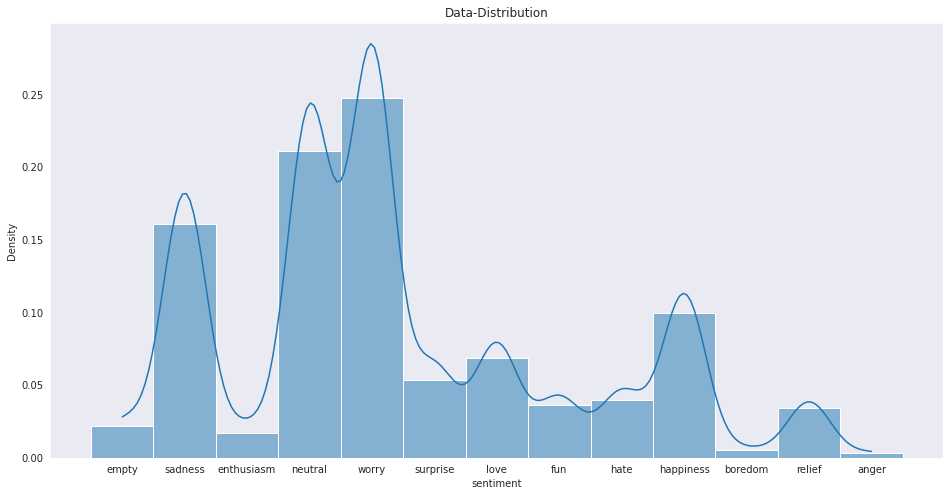

worry         7433
neutral       6340
sadness       4828
happiness     2986
love          2068
surprise      1613
hate          1187
fun           1088
relief        1021
empty          659
enthusiasm     522
boredom        157
anger           98
Name: sentiment, dtype: int64


In [21]:
sns.set_style('dark')

plt.figure(figsize=(16,8))
plt.title('Data-Distribution')
sns.histplot(train_data['sentiment'], kde=True, stat='density')
plt.show()

print(train_data['sentiment'].value_counts())

In [22]:
#Upsampling other classes to make a event count
maxx = 3
all_classes = data.sentiment.unique().tolist()
target_majority = train_data[train_data.sentiment==all_classes[maxx]]

#min_class = [0, 2, 5, 7, 8, 10, 11, 12]

for cl in range(13):
    train_minority = data[data.sentiment==all_classes[cl]]
    train_minority_upsampled = resample(train_minority, replace=True, n_samples=len(target_majority), random_state=123)
    if cl == 0:
        train_upsampled = pd.concat([train_minority_upsampled, target_majority])
        #train_upsampled = pd.concat([train_upsampled, ])
    if cl>0 and cl!=maxx:
        train_upsampled = pd.concat([train_minority_upsampled, train_upsampled])

train_upsampled['sentiment'].value_counts() 

anger         6340
relief        6340
boredom       6340
happiness     6340
hate          6340
fun           6340
love          6340
surprise      6340
worry         6340
enthusiasm    6340
sadness       6340
empty         6340
neutral       6340
Name: sentiment, dtype: int64

In [23]:
content_text = train_data.content.tolist()
all_classes = train_data.sentiment.unique().tolist()

In [24]:
#Tokenizing Words
token_data = tf.keras.preprocessing.text.Tokenizer(num_words=None,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ')
token_data.fit_on_texts(content_text)
#Encodes the text to numbers and creates a sequence out of it
ind_text = token_data.texts_to_sequences(content_text)

#Contains the dictionary of encoded words
word_index = token_data.word_index

In [26]:
'''
print(ind_text[2])
print(content_text[2])
print(list(word_index.keys())[list(word_index.values()).index(2056)]+' '+list(word_index.keys())[list(word_index.values()).index(3222)]+' '+list(word_index.keys())[list(word_index.values()).index(1316)]+' '+list(word_index.keys())[list(word_index.values()).index(100)])
print(all_classes)
'''



[2056, 3222, 1316, 100]
funeral ceremony gloomy friday
funeral ceremony gloomy friday
['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise', 'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger']


In [25]:
#Encoding the labels (classes)
label_token = tf.keras.preprocessing.text.Tokenizer(num_words=len(all_classes), filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')
classes = ' '.join(all_classes)
label_token.fit_on_texts([classes])
label_index = label_token.word_index
print('No. of Labels: ',len(list(label_index)))

label_index = {key:value-1 for key, value in label_index.items()}
inv_label_index = {value:key for key, value in label_index.items()}



No. of Labels:  13


In [26]:
y_train = []
for i in train_data.sentiment:
    y_train.append(label_index.get(i))
y_train = np.array(y_train)
print('Label_shape: ', y_train.shape)


x_train = np.array(ind_text)
max_inp_len = len(x_train[0])
for step, i in enumerate(x_train):
    if len(i) > max_inp_len:
        max_inp_len = len(i)
print('max_input_length: ',max_inp_len)

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen = max_inp_len, padding = 'post')
print('x_train_shape: ',x_train.shape, ', y_train_shape: ', y_train.shape)

Label_shape:  (30000,)
max_input_length:  30
x_train_shape:  (30000, 30) , y_train_shape:  (30000,)


In [27]:
def val_and_test_preprocess(data_v_t, token_data, label_index):
    
    content_text = data_v_t.content.tolist()
    all_classes = data_v_t.sentiment.unique().tolist()
    ind_text = token_data.texts_to_sequences(content_text)
    x_val = np.array(ind_text)

    print('All_Val_samples: ', len(ind_text))
    
    y_val = []
    for i in data_v_t.sentiment:
        y_val.append(label_index.get(i))
    y_val = np.array(y_val)
    print('Label_shape: ', y_val.shape)
    
    return x_val, y_val


print('Val-Processing ...')
x_val, y_val = val_and_test_preprocess(val_data, token_data, label_index)
print(x_val.shape, y_val.shape)
print('---'*20)
print('Test_Preprocessing ...')
x_test, y_test = val_and_test_preprocess(test_data, token_data, label_index)
print(x_test.shape, y_test.shape)

Val-Processing ...
All_Val_samples:  7999
Label_shape:  (7999,)
(7999,) (7999,)
------------------------------------------------------------
Test_Preprocessing ...
All_Val_samples:  1999
Label_shape:  (1999,)
(1999,) (1999,)


In [28]:
#Padding validation and test sets to make it common length
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen = max_inp_len, padding = 'post')
print('x_val_shape: ',x_val.shape, ', y_val_shape: ', y_val.shape)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen = max_inp_len, padding = 'post')
print('x_test_shape: ',x_test.shape, ', y_test_shape: ', y_test.shape)

x_val_shape:  (7999, 30) , y_val_shape:  (7999,)
x_test_shape:  (1999, 30) , y_test_shape:  (1999,)


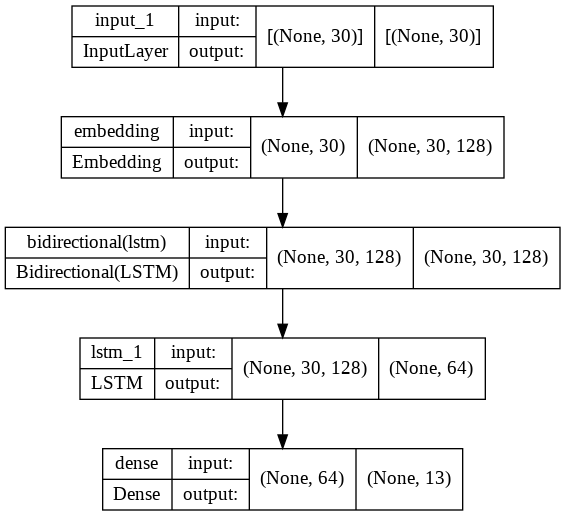

In [29]:

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2)
    
input_1 = tf.keras.layers.Input(shape=(x_train.shape[-1],))
embd_1 = tf.keras.layers.Embedding(input_dim = len(list(word_index)) + 1, output_dim=128)(input_1)
bi_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True, dropout=0.3, recurrent_dropout=0.5), merge_mode = 'concat')(embd_1)
lstm_1 = tf.keras.layers.LSTM(units=64, dropout=0.3, recurrent_dropout=0.5)(bi_1)
dense_1 = tf.keras.layers.Dense(len(all_classes), activation='softmax')(lstm_1)

model = tf.keras.models.Model(inputs = input_1, outputs = dense_1, name='Basic_RNN')
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes =True)

In [30]:
his2 = model.fit(x_train, y_train, epochs=50, validation_data = (x_val, y_val), batch_size=64, callbacks=[stop_early]) #, sample_weight = sample_weights)

print(' -- Model_Evaluation -- ')
(model.evaluate(x_test, y_test))
tf.keras.models.save_model(model, filepath = "./basic_rnn.h5")

Epoch 1/50
469/469 [==============================] - 150s 298ms/step - loss: 2.0916 - accuracy: 0.2461 - val_loss: 2.1125 - val_accuracy: 0.2248
Epoch 2/50
469/469 [==============================] - 127s 272ms/step - loss: 1.9643 - accuracy: 0.2787 - val_loss: 2.0491 - val_accuracy: 0.3139
Epoch 3/50
469/469 [==============================] - 126s 269ms/step - loss: 1.8175 - accuracy: 0.3525 - val_loss: 2.0852 - val_accuracy: 0.3247
Epoch 4/50
469/469 [==============================] - 126s 269ms/step - loss: 1.6306 - accuracy: 0.4326 - val_loss: 2.2607 - val_accuracy: 0.3179
 -- Model_Evaluation -- 
63/63 [==============================] - 1s 20ms/step - loss: 2.2150 - accuracy: 0.3262


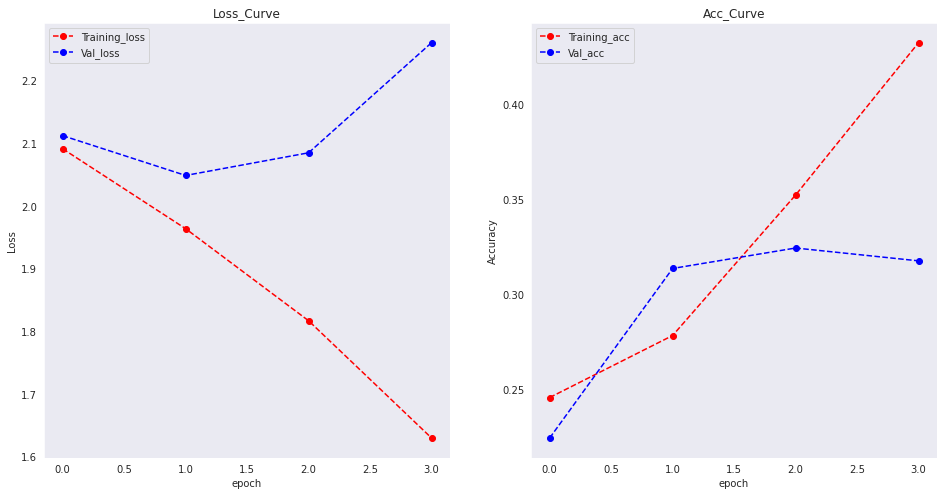

--Confusion_Matrix--
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   4   0   3   3   1   1   1   8   1   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 16  10  16 201  70  25  35  27   3  85   0  34   0]
 [ 12  24  13 121  71  29  31  23  16  63   3  31   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   2   1  20   7   6 114   6   0  48   0   8   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  3  24  22 117  75  41 157  57   3 262   2  39   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]
f1_score:  0.3261630815407704
Pr.:  0.3261630815407704
Re.:  0.3261630815407704


In [31]:


his_2 = his2.history

fig, axs = plt.subplots(1,2, figsize=(16,8))

axs[0].set_title('Loss_Curve')
ep = range(len(his_2['loss']))
axs[0].plot(ep, his_2['loss'],'o--r',label = 'Training_loss')
axs[0].plot(ep, his_2['val_loss'],'o--b',label = 'Val_loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].set_title('Acc_Curve')
ep = range(len(his_2['loss']))
axs[1].plot(ep, his_2['accuracy'],'o--r',label = 'Training_acc')
axs[1].plot(ep, his_2['val_accuracy'],'o--b',label = 'Val_acc')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()


ypred = model.predict(x_test)
ypred = np.argmax(ypred, axis=-1)
conf_matrix  = confusion_matrix(ypred, y_test)

print('--Confusion_Matrix--')

print(conf_matrix)

print('f1_score: ',f1_score(y_test, ypred, average='micro'))
print('Pr.: ',precision_score(y_test, ypred, average='micro'))
print('Re.: ',recall_score(y_test, ypred, average='micro'))

In [32]:
## inference
index = {}
for val, key in enumerate(word_index.keys()):
    index[val+1] = key 
inv_word_index = index
inv_word_index[0] = ''


def reverser(inp):
    st = ''
    for i in inp:
        st += ' ' + str(inv_word_index.get(i))
    return st

def predict():
    seed = random.randint(0, x_test.shape[0])
    x_seed = x_test[seed]
    act = y_test[seed]
    st = reverser(x_seed)
    print('Input_Sentence: ', st)
    print('--'*20)
    print('Actual_emotion: ', inv_label_index.get(act))
    pred = (np.argmax(model.predict(x_seed.reshape(1,-1)), axis=-1).tolist())
    print('--'*20)
    print('Predicted_emotion: ', inv_label_index.get(pred[-1]))

for _ in range(5):
    print('**'*50)
    predict()
    print('**'*50)
    print()

****************************************************************************************************
Input_Sentence:   tidied whole flat b today heading german bakery breakfast followed walk park                  
----------------------------------------
Actual_emotion:  relief
----------------------------------------
Predicted_emotion:  neutral
****************************************************************************************************

****************************************************************************************************
Input_Sentence:   listening dead ocean actually listened twice row short                      
----------------------------------------
Actual_emotion:  worry
----------------------------------------
Predicted_emotion:  neutral
****************************************************************************************************

****************************************************************************************************
Input_Sentence:   

In [33]:
#---------------------- Using our model to make predictions on democrat and republican tweets -------------------------------------


In [34]:
#------ APPROACH 1: Using RNNS ---------

In [35]:
democrat_list[:3]

['today senate dems vote savetheinternet proud support similar netneutrality legislation house',
 'winterhavensun winter resident alta vista teacher one several recognized repdarrensoto national teacher apprecia',
 'nbclatino repdarrensoto noted hurricane maria left approximately billion damages congress allocated']

In [36]:
#Convert into token vectors, and padd to standard length
tok_text_dem = token_data.texts_to_sequences(democrat_list)
tok_text_dem = tf.keras.preprocessing.sequence.pad_sequences(tok_text_dem, maxlen = max_inp_len, padding = 'post')



In [37]:
#Making predictions for 5000 random samples
from tqdm import tqdm
dem_predictions=[]
def predict_dem():
    
    for _ in tqdm(range(5000)):
      seed = random.randint(0, len(tok_text_dem)-1)
      x_seed = tok_text_dem[seed]      
      st = reverser(x_seed)
      pred = (np.argmax(model.predict(x_seed.reshape(1,-1)), axis=-1).tolist())
      dem_predictions.append(inv_label_index.get(pred[-1]))

predict_dem()

len(dem_predictions)

np.unique(dem_predictions, return_counts= True)

100%|██████████| 5000/5000 [05:36<00:00, 14.85it/s]


(array(['happiness', 'love', 'neutral', 'sadness', 'worry'], dtype='<U9'),
 array([1101,   78, 1513,  171, 2137]))

In [38]:
#------------ REPUB --------------
#Making predictions for 5000 random republicans
tok_text_rep = token_data.texts_to_sequences(republican_list)
tok_text_rep = tf.keras.preprocessing.sequence.pad_sequences(tok_text_rep, maxlen = max_inp_len, padding = 'post')

from tqdm import tqdm
rep_predictions=[]
def predict_repub():
    
    for _ in tqdm(range(5000)):
      seed = random.randint(0, len(tok_text_rep)-1)      
      x_seed = tok_text_rep[seed]      
      st = reverser(x_seed)
      pred = (np.argmax(model.predict(x_seed.reshape(1,-1)), axis=-1).tolist())
      rep_predictions.append(inv_label_index.get(pred[-1]))

predict_repub()

np.unique(rep_predictions, return_counts=True)


100%|██████████| 5000/5000 [05:14<00:00, 15.89it/s]


(array(['happiness', 'love', 'neutral', 'sadness', 'surprise', 'worry'],
       dtype='<U9'), array([1299,   92, 1607,  123,    1, 1878]))

In [44]:
#------------------------- Plotting Results -----------------------------

In [63]:
print(dem_counts)
print(rep_counts)
dem_counts = list(np.unique(dem_predictions, return_counts= True)[1])
rep_counts = list(np.unique(rep_predictions, return_counts= True)[1])
rl = sorted(list(np.unique(rep_predictions, return_counts= True)[0]))
dl = sorted(list(np.unique(dem_predictions, return_counts= True)[0]))

labels=[]
dem_counts_graph=[]
rep_counts_graph=[]
dem = dict(zip(sorted(list(np.unique(dem_predictions, return_counts= True)[0])),list(np.unique(dem_predictions, return_counts= True)[1])))
rep = dict(zip(sorted(list(np.unique(rep_predictions, return_counts= True)[0])), list(np.unique(rep_predictions, return_counts= True)[1])))


for item in rl:
  if item in dl and item not in labels:
    labels.append(item)
    dem_counts_graph.append(dem[item])
    rep_counts_graph.append(rep[item])

  elif item not in dl and item not in labels:
    labels.append(item)
    rep_counts_graph.append(rep[item])
    dem_counts_graph.append(0)


for item in dl:
  if item in rl and item not in labels:
    labels.append(item)
    dem_counts_graph.append(dem[item])
    rep_counts_graph.append(rep[item])

  elif item not in rl and item not in labels:
    labels.append(item)
    rep_counts_graph.append(0)
    dem_counts_graph.append(dem[item])


print(labels)
print(dem_counts_graph)
print(rep_counts_graph)

[1101, 78, 1513, 171, 2137]
[1299, 92, 1607, 123, 1, 1878]
['happiness', 'love', 'neutral', 'sadness', 'surprise', 'worry']
[1101, 78, 1513, 171, 0, 2137]
[1299, 92, 1607, 123, 1, 1878]


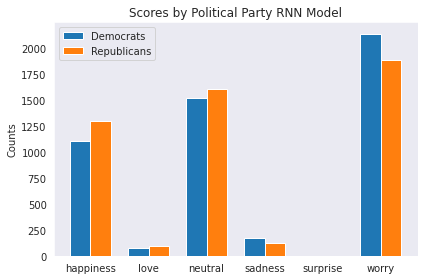

In [64]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dem_counts_graph, width, label='Democrats')
rects2 = ax.bar(x + width/2, rep_counts_graph, width, label='Republicans')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Scores by Political Party RNN Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
# ------------------------- Modeling the data with T5 trained on emotions ----------------------------------

In [56]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 84 kB 2.5 MB/s 
     |████████████████████████████████| 596 kB 60.5 MB/s 
     |████████████████████████████████| 880 kB 47.2 MB/s 
     |████████████████████████████████| 6.6 MB 27.6 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=2d22ad8995521159b30db1b869e3e5ef91f1ae0ab4e3426fe0637524be000646
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.2 MB/s 


In [57]:
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")

model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")

def get_emotion(text):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

  output = model.generate(input_ids=input_ids,
               max_length=2)
  
  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]
  return label
  
get_emotion("i feel as if i havent blogged in ages are at least truly blogged i am doing an update cute")

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

'<pad> joy'

In [58]:
democrat_T5_results =[]
republican_T5_results = []


In [59]:
for _ in tqdm(range(5000)):
      seed1 = random.randint(0, len(democrat_list)-1)
      seed2 = random.randint(0, len(republican_list)-1)
      democrat_T5_results.append(get_emotion(democrat_list[seed1])[6:])
      republican_T5_results.append(get_emotion(republican_list[seed2])[6:])



100%|██████████| 5000/5000 [34:21<00:00,  2.43it/s]


In [ ]:
dem_counts_T5 = list(np.unique(democrat_T5_results, return_counts= True)[1])
print(np.unique(democrat_T5_results, return_counts= True)[0])
rep_counts_T5 = list(np.unique(republican_T5_results, return_counts=True)[1])
print(np.unique(republican_T5_results, return_counts= True)[0])

['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']
['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']


In [ ]:
dem_counts_T5

[1554, 788, 2320, 32, 278, 28]

In [ ]:
rep_counts_T5

[1222, 695, 2800, 24, 242, 17]

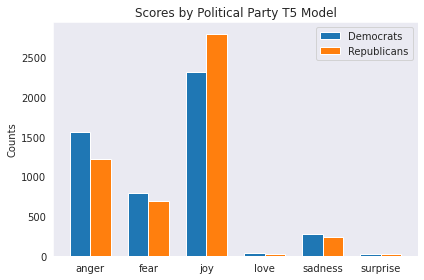

In [ ]:
labels = ['anger','fear' ,'joy' ,'love' ,'sadness' ,'surprise']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dem_counts_T5, width, label='Democrats')
rects2 = ax.bar(x + width/2, rep_counts_T5, width, label='Republicans')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Scores by Political Party T5 Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()